In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import warnings

warnings.filterwarnings('ignore')

## Single alpha

In [2]:

YEAR = 252

def read_factors(model='ff3'):
    
    if model == 'ff3':
        factors = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', index_col=0, parse_dates=True)
        factors = factors.drop('RF', axis=1)
        factors.columns = [c.lower().strip() for c in factors.columns]
        factors_list = list(factors.columns)
        for f in factors_list:
            factors[f] = pd.to_numeric(factors[f], errors='coerce')/100
        factors = factors.dropna()
    elif model == 'ff5':
        factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', index_col=0, parse_dates=True)
        factors = factors.drop('RF', axis=1)
        factors.columns = [c.lower().strip() for c in factors.columns]
        factors_list = list(factors.columns)
        for f in factors_list:
            factors[f] = pd.to_numeric(factors[f], errors='coerce')/100
        factors = factors.dropna()
    elif model == 'ffc4':
        factors_1, _ = read_factors(model='ff3')
        factors_2 = pd.read_csv('F-F_Momentum_Factor_daily.CSV', index_col=0, parse_dates=True)
        factors_2.columns = [c.lower().strip() for c in factors_2.columns]
        for f in factors_2.columns:
            factors_2[f] = pd.to_numeric(factors_2[f], errors='coerce')/100
        factors = factors_1.merge(factors_2, left_index=True, right_index=True, how='inner')
        factors_list = list(factors.columns)
        factors = factors.dropna()
    else:
        raise ValueError("The model must be one of 'ff3', 'ff5' or 'ffc4'")

    return factors, factors_list
factors, factors_list = read_factors(model='ffc4')

risk_free = pd.read_csv('Pairs_SP500_FPT/DTB6.csv', index_col=0, parse_dates=True)
risk_free = risk_free.rename(columns={
    'DTB6': 'rf'
})
risk_free['rf'] = pd.to_numeric(risk_free['rf'], errors='coerce')
risk_free = risk_free.dropna()
risk_free['rf'] = risk_free['rf']/100/365

vol_spread = pd.read_csv('Pairs_SP500_FPT/spx_impl_minus_hist_vol.csv', index_col=0, parse_dates=True)
vol_spread['vol_spread'] /= 100

vol_premium = pd.read_csv('Pairs_SP500_FPT/1mo_rolling_impl_minus_hist_vol.csv', index_col=0, parse_dates=True)
vol_premium /= 100
melted_vol_premium = vol_premium.reset_index().melt(id_vars='Date', var_name='stock', value_name='vol_premium')

market_spread_over_sp = pd.read_csv('Pairs_SP500_FPT/1mo_rolling_hist_stock_minus_sp_vol.csv', index_col=0, parse_dates=True)
market_spread_over_sp /= 100
melted_market_spread_over_sp = market_spread_over_sp.reset_index().melt(id_vars='Date', var_name='stock', value_name='spread_over_sp')

factors['mkt-rf'] = factors['mkt-rf'].astype(np.float32)
factors['smb'] = factors['smb'].astype(np.float32)
factors['hml'] = factors['hml'].astype(np.float32)
factors['mom'] = factors['mom'].astype(np.float32)
rets['rets'] = rets['rets'].astype(np.float32)
risk_free['rf'] = risk_free['rf'].astype(np.float32)
vol_spread['vol_spread'] = vol_spread['vol_spread'].astype(np.float32)
melted_market_spread_over_sp['stock'] = melted_market_spread_over_sp['stock'].astype('category')
melted_market_spread_over_sp['spread_over_sp'] = melted_market_spread_over_sp['spread_over_sp'].astype(np.float32)
melted_vol_premium['stock'] = melted_vol_premium['stock'].astype('category')
melted_vol_premium['vol_premium'] = melted_vol_premium['vol_premium'].astype(np.float32)

full_dataset = rets.merge(factors, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(risk_free, left_index=True, right_index=True, how='inner')
# full_dataset = full_dataset.merge(vol_spread, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(melted_market_spread_over_sp, left_index=True, right_on='Date', how='left')
# full_dataset = full_dataset.merge(melted_vol_premium, left_on=['Date', 'stock'], right_on=['Date', 'stock'], how='left')
# full_dataset = benchmark.merge(factors, left_index=True, right_index=True, how='inner').merge(risk_free, left_index=True, right_index=True, how='inner').merge(vol_spread, left_index=True, right_index=True, how='inner')
full_dataset['exc_rets'] = full_dataset['rets'] - full_dataset['rf']
# full_dataset = full_dataset.dropna()
full_dataset.index = full_dataset['Date']
full_dataset = full_dataset.drop(['Date'], axis=1)
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.reset_index()
full_dataset = full_dataset.set_index(['stock', 'Date'])


df = pd.read_csv('alpha_regression_v3.csv', index_col=0)
start = min(df['start'])
end = max(df['end'])

dataset = full_dataset.reset_index()
dataset = dataset[(dataset['Date']>=start)&(dataset['Date']<end)]
dataset = dataset.set_index(['stock','Date'])
Y = dataset['exc_rets']
factors_list = list(set(dataset.columns) - set(['rets','exc_rets','rf']))
X = dataset[factors_list]
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
print(result)
alpha = result.params.const
print(f'Alpha: {alpha}')

NameError: name 'rets' is not defined

## Alpha visualization

In [41]:
rets = pd.read_csv('returns_spx_v11.csv')
rets = rets.rename(columns={
    'Daily_Return': 'rets'
})
rets['Date'] = pd.to_datetime(rets['Date'])
rets = rets.set_index('Date')

df = pd.read_csv('alpha_regression_v3.csv', index_col=0)
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])
rets = rets[(rets.index>=df['start'].iloc[0])&(rets.index<=df['end'].iloc[-1])]
df = df.merge(rets, how='outer', left_on='start', right_index=True)
df = df.sort_values(by='start')
df = df.reset_index(drop=True)
df['alpha'] = df['alpha'].ffill()
df['mean_exc_strat_rets'] = df['mean_exc_strat_rets'].ffill()
df.loc[:,'avg_alpha'] = alpha

benchmark = pd.read_csv('returns_sp500.csv', index_col=0, parse_dates=True)
benchmark = benchmark[(benchmark.index >= rets.index[0])&(benchmark.index <= rets.index[-1])]
# benchmark = benchmark[benchmark.index.isin(rets.index)]
df

,end,start,alpha,mean_exc_strat_rets,rets,avg_alpha
0,2009-02-27,2008-11-28,-0.000619,-0.000776,-0.031841,0.000391
1,NaT,2008-12-01,-0.000619,-0.000776,0.015323,0.000391
2,NaT,2008-12-02,-0.000619,-0.000776,0.010784,0.000391
3,NaT,2008-12-03,-0.000619,-0.000776,-0.008898,0.000391
4,NaT,2008-12-04,-0.000619,-0.000776,0.018422,0.000391
...,...,...,...,...,...,...
3615,NaT,2023-05-24,-0.000420,0.000305,-0.001533,0.000391
3616,NaT,2023-05-25,-0.000420,0.000305,0.004978,0.000391
3617,NaT,2023-05-26,-0.000420,0.000305,-0.000718,0.000391
3618,NaT,2023-05-30,-0.000420,0.000305,0.000086,0.000391


Text(0, 0.5, 'Cumulative returns')

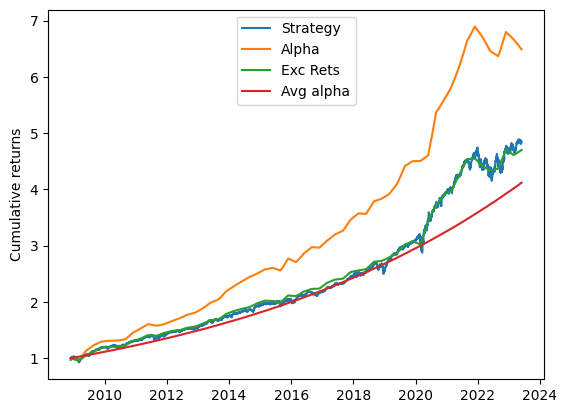

In [42]:
fig, ax1 = plt.subplots()
ax1.plot(rets.index, (1+rets['rets']).cumprod())
ax1.plot(df['start'], (1+df['alpha']).cumprod())
ax1.plot(df['start'], (1+df['mean_exc_strat_rets']).cumprod())
ax1.plot(df['start'], (1+df['avg_alpha']).cumprod())
# ax1.plot(benchmark.index, (1+benchmark['rets']).cumprod())
ax1.legend(['Strategy','Alpha', 'Exc Rets','Avg alpha','SP500'], loc='upper center')
ax1.set_ylabel('Cumulative returns')

## Alpha regression

Ratios
- MKTVal: daily_prices[resample].market_cap
- BTM: ratios.book_value_per_share / daily_prices[resample].price
- PER: ratios.per
- EVEBIT: ratios.EV_EBIT
- EVEBITDA: ratios.EV_EBITDA
- GPA: (income_statement.sales - income_statement.COGS_incl_depreciation_and_amortization)/ balance_sheet.total_assets
- ROC: income_statement.consolidated_net_income / (daily_prices[resample].market_cap + balance_sheet.total_liabilities)
- ROCD: NO
- MOM: NO

(listing.common_shares_outstanding * daily_prices[resample].price + balance_sheet.total_liabilities - balance_sheet.cash_and_short-term_investments)

In [3]:
bs = pd.read_excel('20240529/balance_sheet.xlsx', index_col=0)
bs = bs[['id', 'date', 'total_assets', 'total_liabilities']]
ratios = pd.read_excel('20240529/ratios.xlsx', index_col=0)
ratios = ratios[['id','date','EV_EBIT','EV_EBITDA','PER','book_value_per_share']]
istatement = pd.read_excel('20240529/income_statement.xlsx', index_col=0)
istatement = istatement[['id','date','sales','COGS_incl_depreciation_and_amortization','consolidated_net_income']]
dprices = pd.read_csv('20240529/daily_prices.csv', index_col=0)
dprices = dprices[['id', 'date', 'price', 'market_cap']]
dprices['date'] = pd.to_datetime(dprices['date'])
symbols = pd.read_excel('20240529/listing.xlsx', index_col=0)
symbols = symbols.reset_index()
symbols = symbols[['id','symbol']]
comp_data = bs.merge(ratios,on=['id','date'], how='outer').merge(istatement,on=['id','date'], how='outer').merge(dprices,on=['id','date'], how='left').merge(symbols,on='id')

In [4]:
comp_data['MKTVal'] = comp_data['market_cap']
comp_data['BTM'] = comp_data['book_value_per_share']/comp_data['market_cap']
comp_data = comp_data.rename(columns={
    'per': 'PER',
    'EV_EBIT': 'EVEBIT',
    'EV_EBITDA': 'EVEBITDA',
})
comp_data['GPA'] = (comp_data['sales'] - comp_data['COGS_incl_depreciation_and_amortization'])/comp_data['total_assets']
comp_data['ROC'] = comp_data['consolidated_net_income']/(comp_data['market_cap']+comp_data['total_liabilities'])
comp_data = comp_data[['symbol','date','MKTVal','BTM','PER','EVEBIT','EVEBITDA','GPA','ROC']]
comp_data = comp_data.dropna()
comp_data.head()

,symbol,date,MKTVal,BTM,PER,EVEBIT,EVEBITDA,GPA,ROC
0,CTAS-US,2000-02-29,4455.627285,0.000912,31.445613,20.806898,15.422970,0.109155,0.009853
1,CTAS-US,2000-05-31,7368.151672,0.000841,42.173871,23.603222,17.973103,0.179737,0.006681
2,CTAS-US,2000-08-31,6994.220529,0.000927,38.130734,21.783378,16.567271,0.118323,0.006775
3,CTAS-US,2000-11-30,8571.864257,0.000795,44.946175,25.693125,19.683134,0.117704,0.006218
4,CTAS-US,2001-02-28,6077.888964,0.001175,28.583833,17.858309,13.683863,0.110905,0.008325


In [5]:
df = pd.read_csv('alpha_regression_v3.csv', index_col=0)
comp_data = comp_data.sort_values(by='date',ascending=True)
new_alphas = df[['end','alpha']].rename(columns={'end':'date'})
new_alphas['date'] = pd.to_datetime(new_alphas['date'])
new_alphas = new_alphas.set_index('date')
if comp_data['date'].min() < new_alphas.index.min():
    f_comp_data = comp_data[comp_data['date'] >= new_alphas.index.min()]
    f_new_alphas = new_alphas.copy()
else:
    f_new_alphas = new_alphas[new_alphas.index >= comp_data['date'].min()]
    f_comp_data = comp_data.copy()

if f_comp_data['date'].max() > f_new_alphas.index.max():
    f_comp_data = f_comp_data[f_comp_data['date'] <= f_new_alphas.index.max()]
    f_new_alphas = f_new_alphas.copy()
else:
    f_new_alphas = f_new_alphas[f_new_alphas.index <= f_comp_data['date'].max()]
    f_comp_data = f_comp_data.copy()

df = f_new_alphas.merge(f_comp_data, left_index=True, right_on='date', how='outer')

def closest_future_date(current_date, dates_list):
    future_dates = dates_list[dates_list >= current_date]
    if not future_dates.empty:
        return future_dates.iloc[0]
    else:
        return np.nan  # Or handle the case where no future date is available

# Apply the function to the DataFrame
dates_list = pd.Series(f_new_alphas.index)
f_comp_data['adj_date'] = f_comp_data['date'].apply(lambda x: closest_future_date(x, dates_list))

f_comp_data = f_comp_data.drop('date', axis=1)
f_comp_data = f_comp_data.rename(columns={
    'adj_date': 'date'
}).set_index('date')
df = f_comp_data.merge(f_new_alphas, left_index=True, right_index=True)
df['symbol'] = df['symbol'].astype('category')
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['symbol','date'])

Y = df['alpha']
factors_list = list(set(df.columns) - set(['alpha']))
X = df[factors_list]
X = (X - X.min())/(X.min() - X.max())
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,alpha,R-squared:,0.0109
Estimator:,PanelOLS,R-squared (Between):,-1.4810
No. Observations:,21241,R-squared (Within):,0.0109
Date:,"Fri, Aug 23 2024",R-squared (Overall):,-0.0284
Time:,22:05:55,Log-likelihood,1.279e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,32.638
Entities:,442,P-value,0.0000
Avg Obs:,48.057,Distribution:,"F(7,20792)"
Min Obs:,2.0000,,
Max Obs:,58.000,F-statistic (robust):,32.638


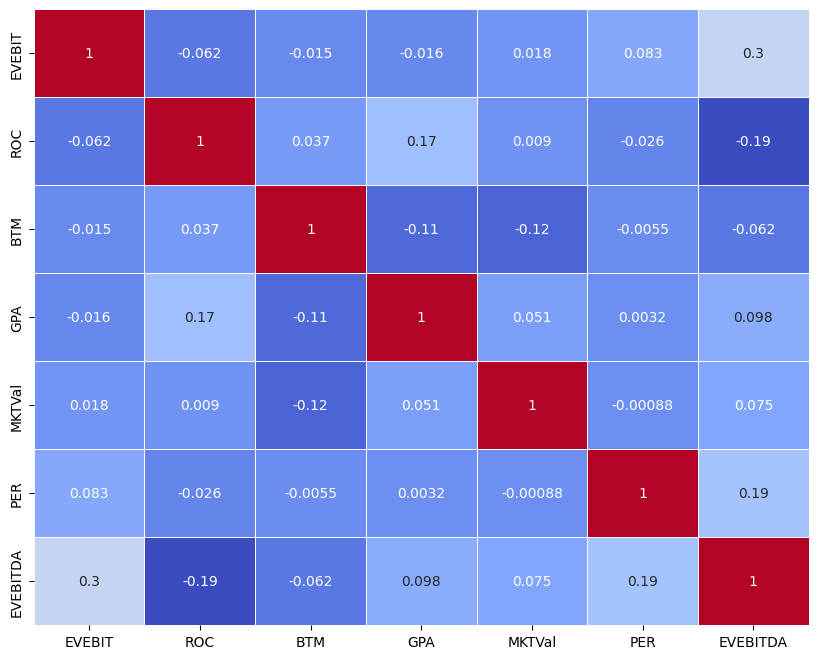

In [8]:
aux = X.copy()
plt.figure(figsize=(10, 8))  # Optional: Adjusts the size of the plot
sns.heatmap(aux.corr(), annot=True, cmap='coolwarm', linewidths=0.5, cbar=False)
plt.show()

In [5]:
Y = df['alpha']
factors_list = list(set(df.columns) - set(['alpha', 'EVEBIT']))
X = df[factors_list]
X = (X - X.min())/(X.min() - X.max())
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,alpha,R-squared:,0.0109
Estimator:,PanelOLS,R-squared (Between):,-1.4772
No. Observations:,21241,R-squared (Within):,0.0109
Date:,"Fri, Aug 23 2024",R-squared (Overall):,-0.0284
Time:,05:05:29,Log-likelihood,1.279e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,38.047
Entities:,442,P-value,0.0000
Avg Obs:,48.057,Distribution:,"F(6,20793)"
Min Obs:,2.0000,,
Max Obs:,58.000,F-statistic (robust):,38.047


In [14]:
Y = df['alpha']
factors_list = list(set(df.columns) - set(['alpha', 'EVEBIT','PER']))
X = df[factors_list]
X = (X - X.min())/(X.min() - X.max())
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,alpha,R-squared:,0.0108
Estimator:,PanelOLS,R-squared (Between):,-1.4746
No. Observations:,21241,R-squared (Within):,0.0108
Date:,"Fri, Aug 23 2024",R-squared (Overall):,-0.0284
Time:,05:09:17,Log-likelihood,1.279e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,45.545
Entities:,442,P-value,0.0000
Avg Obs:,48.057,Distribution:,"F(5,20794)"
Min Obs:,2.0000,,
Max Obs:,58.000,F-statistic (robust):,45.545


In [15]:
Y = df['alpha']
factors_list = list(set(df.columns) - set(['alpha', 'EVEBIT','PER','GPA']))
X = df[factors_list]
X = (X - X.min())/(X.min() - X.max())
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,alpha,R-squared:,0.0108
Estimator:,PanelOLS,R-squared (Between):,-1.4329
No. Observations:,21241,R-squared (Within):,0.0108
Date:,"Fri, Aug 23 2024",R-squared (Overall):,-0.0275
Time:,05:09:44,Log-likelihood,1.279e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,56.742
Entities:,442,P-value,0.0000
Avg Obs:,48.057,Distribution:,"F(4,20795)"
Min Obs:,2.0000,,
Max Obs:,58.000,F-statistic (robust):,56.742


In [12]:
import scipy

In [16]:
alphas = df['alpha'].groupby(level='date').first()
moments = scipy.stats.describe(alphas)
print(moments.mean*4)
print((moments.variance*4)**.5)
print(moments.skewness)
print(moments.kurtosis)

0.002059734811825466
0.0012371786424261182
0.73966564796349
1.7951597775401282
